# <a id="1">Contents</a>
## [1. Introduction](#intro)
## [2. Data Analysis](#data-analysis)

# <a id="intro">1. Introduction</a>  

Due to competition, retailers aim to increase profits and reduce costs, increasing the profit margin for perishable food products. This means that avoiding costs due to lost sales, and because of the short-shelf life of their products, ensuring that there is no build up of inventory. Effecient forecasting system can result in reduced inventory, be flexible to changes and increase profits. 

Time series is a series of data points indexed by time typically in an ordered equally spaced manner. Time serves as the only feature in this format of data, and behavior of the data is analyzed through time. Time series forecasting uses past observations of the same variable to develop a model describing the underlying relationship. The model is then used to extrapolate time series into the future. This approach is useful when there are no other explanatory variables influencing the generation of the underlying data. 

## <a id="data-analysis">2. Data Analysis</a>

In [65]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tools.eval_measures import rmse

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

import urllib
from sqlalchemy import create_engine

# Custom upload with connection string
from engine_info import server_info

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams

In [6]:
# Creating a connection to AWS RDS
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [7]:
# Upload Durban Fresh Produce Market sales data
sales = pd.read_sql_table(
    table_name='Durban_Fresh_produce_market',
    con=connection,
    parse_dates=['Date']
)

## <a id="data-overview">2.1 Data Overview</a>

In [8]:
# Check the first five rows
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,PINEAPPLE QUEEN VICTORIA,8.00,,LM080,NATAL,50.00,90.00,83.65,15810,189,1512,296,2020-10-15
1,PLUM- AFRICAN ROSE,5.30,1A,MA053,NATAL,100.00,100.00,100.00,100,1,5.3,32,2020-10-15
2,PLUM- AFRICAN ROSE,5.00,1A,PD050,OTHER AREAS,250.00,260.00,258.89,2330,9,45,0,2020-10-15
3,PLUM PIONEER,5.30,1A,MA053,CAPE,0.00,0.00,0.00,0,0,0,4,2020-10-15
4,PLUM PIONEER,8.00,1A,PE080,CAPE,0.00,0.00,0.00,0,0,0,194,2020-10-15


In [9]:
# View datatype of each column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169088 entries, 0 to 169087
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     169088 non-null  object        
 1   Weight_Kg       169088 non-null  object        
 2   Size_Grade      169088 non-null  object        
 3   Container       169088 non-null  object        
 4   Province        169088 non-null  object        
 5   Low_Price       169088 non-null  object        
 6   High_Price      169088 non-null  object        
 7   Average_Price   169088 non-null  object        
 8   Sales_Total     169088 non-null  object        
 9   Total_Qty_Sold  169088 non-null  object        
 10  Total_Kg_Sold   169088 non-null  object        
 11  Stock_On_Hand   169088 non-null  object        
 12  Date            169088 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(12)
memory usage: 16.8+ MB


Based on the data type for each column above, some of the columns are not on their appropriate data format. 

In [10]:
# Convert some of the columns to their appropriate data type
float_columns = ['Weight_Kg', 'Low_Price', 'High_Price', 'Average_Price', 
                 'Sales_Total', 'Total_Kg_Sold', 'Total_Qty_Sold', 'Stock_On_Hand']


# Convert the columns to numeric
for col in float_columns:
    # sales[col] = sales[col].astype(float)
    sales[col] = pd.to_numeric(sales[col])

In [11]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169088 entries, 0 to 169087
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     169088 non-null  object        
 1   Weight_Kg       169088 non-null  float64       
 2   Size_Grade      169088 non-null  object        
 3   Container       169088 non-null  object        
 4   Province        169088 non-null  object        
 5   Low_Price       169088 non-null  float64       
 6   High_Price      169088 non-null  float64       
 7   Average_Price   169088 non-null  float64       
 8   Sales_Total     169087 non-null  float64       
 9   Total_Qty_Sold  169087 non-null  float64       
 10  Total_Kg_Sold   169088 non-null  float64       
 11  Stock_On_Hand   169087 non-null  float64       
 12  Date            169088 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 16.8+ MB


In [13]:
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,50.0,90.0,83.65,15810.0,189.0,1512.0,296.0,2020-10-15
1,PLUM- AFRICAN ROSE,5.3,1A,MA053,NATAL,100.0,100.0,100.00,100.0,1.0,5.3,32.0,2020-10-15
2,PLUM- AFRICAN ROSE,5.0,1A,PD050,OTHER AREAS,250.0,260.0,258.89,2330.0,9.0,45.0,0.0,2020-10-15
3,PLUM PIONEER,5.3,1A,MA053,CAPE,0.0,0.0,0.00,0.0,0.0,0.0,4.0,2020-10-15
4,PLUM PIONEER,8.0,1A,PE080,CAPE,0.0,0.0,0.00,0.0,0.0,0.0,194.0,2020-10-15


In [14]:
# Check for the number of days in the database
print(f"{sales['Date'].nunique()} days recorded in the database")

168 days recorded in the database


In [15]:
# Remove days whereby total sales equal 0 because it registers average_price as zero.
filtered_sales = sales[sales['Sales_Total'] != 0]

In [17]:
print(f"{filtered_sales['Date'].nunique()} days recorded in the database after removing rows with zero sales")

168 days recorded in the database after removing rows with zero sales


Therefore no days were lost due after removing the rows which had items not sold on that particular day.

In [18]:
# EXAMPLE
# Check PINEAPPLE commodity to observe daily sales
sales[(sales['Commodities'] == 'PINEAPPLE QUEEN VICTORIA') & (sales['Container'] == 'LM080') & (sales['Province'] == 'NATAL')].sort_values('Date').head(20)

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
76795,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,340.0,4.0,32.0,0.0,2019-12-11
76796,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,1125.0,15.0,120.0,0.0,2019-12-11
50737,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,65.0,65.0,65.00,29120.0,448.0,3584.0,2.0,2019-12-12
50738,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,56.0,56.00,7448.0,133.0,1064.0,260.0,2019-12-12
50739,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,40.0,40.0,40.00,1760.0,44.0,352.0,6.0,2019-12-12
50740,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,60.0,85.0,61.89,21784.0,352.0,2816.0,300.0,2019-12-12
50736,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,75.0,74.87,56830.0,759.0,6072.0,32.0,2019-12-12
50735,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,74120.0,872.0,6976.0,637.0,2019-12-12
21824,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,7140.0,84.0,672.0,605.0,2019-12-14
21825,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,14400.0,192.0,1536.0,180.0,2019-12-14


Based on the above table, it can be seen that multiple sales of the same product are taking place on the same day, which means that the data has to be consolidated to one day for some of these products.

In [19]:
# Consolidation of repeated sales in a single day of the same product to one day
df = filtered_sales.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date']
    )[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum
        }
)

In [20]:
df

Low_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                    
                  A8075                7.5       HABANERO YELLOW         2020-07-01      350.0   
                                                                         2020-07-08      350.0   
                                                                         2020-07-09      350.0   
                                                                         2020-07-14      350.0   
                                                                         2020-07-20      300.0   
...                                                                                        ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        8.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                                                                         2020-06-19        5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19       20.0   

                                                                                     High_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                     
                  A8075                7.5       HABANERO YELLOW         2020-07-01       350.0   
                                                                         2020-07-08       350.0   
                                                                         2020-07-09       350.0   
                                                                         2020-07-14       350.0   
                                                                         2020-07-20       320.0   
...                                                                                         ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        10.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        10.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23         5.0   
                                                                         2020-06-19         5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19        20.0   

                                                                                     Sales_Total  \
Province          Container Size_Grade Weight_Kg Commodities             Date                      
                  A8075                7.5       HABANERO YELLOW         2020-07-01        700.0   
                                                                         2020-07-08       1400.0   
                                                                         2020-07-09       1400.0   
                                                                         2020-07-14       1050.0   
                                                                         2020-07-20        620.0   
...                                                                                          ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10       1080.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23       5470.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23       1440.0   
                                                                         2020-06-19        835.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19         20.0   

                                                                                     Total_Qty_Sold  \
Province          Container Size_Grade Weight_Kg Commodities             Date                         
               

In [21]:
# Reset index to ensure that every row in every column has data.
df.reset_index(inplace=True)

In [22]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,700.0,2.0,15.0,6.0
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,1400.0,4.0,30.0,12.0
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,1400.0,4.0,30.0,12.0
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,1050.0,3.0,22.5,2.0
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,620.0,2.0,15.0,0.0


In [23]:
# Calculate average price per kilogram of each item
df['avg_per_kg'] = round(df['Sales_Total'] / df['Total_Kg_Sold'], 2)

# ?????? Filter for one product

In [24]:
# Check which product is sold on a daily basis
day_count = sales['Date'].nunique()
df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities'])['Commodities'].value_counts().apply(lambda x: x / day_count).sort_values(ascending=False)

Province           Container  Size_Grade  Weight_Kg  Commodities                Commodities              
CAPE               EC120      1S          12.0       APPLE GOLDEN DELICIOUS     APPLE GOLDEN DELICIOUS       1.000000
NATAL              BI100                  10.0       CAULIFLOWER                CAULIFLOWER                  0.988095
TRANSVAAL          AE050                  5.0        CARROTS                    CARROTS                      0.988095
NATAL              NE005                  0.5        CURRY LEAVES               CURRY LEAVES                 0.988095
                   BI100                  10.0       LETTUCE                    LETTUCE                      0.988095
                                                                                                               ...   
                   BX250                  25.0       PINEAPPLE QUEEN VICTORIA   PINEAPPLE QUEEN VICTORIA     0.005952
CAPE               M4155      1M          15.5       PEAR WILLIAM BO

Based on the results above, **APPLE GOLDEN DELICIOUS** has been sold for every day that is recorded in the database. For this notebook, this product will be used as a template for developing a forecasting model.

In [25]:
filtered_df = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') &
    (df['Province'] == 'CAPE')
]

In [26]:
filtered_df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_per_kg
4675,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-11,50.0,140.0,3840.0,33.0,396.0,1117.0,9.70
4676,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-12,100.0,144.0,129546.0,1151.0,13812.0,2070.0,9.38
4677,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-14,100.0,140.0,7734.0,63.0,756.0,2865.0,10.23
4678,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-23,40.0,200.0,99673.0,1519.0,18228.0,6017.0,5.47
4679,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-30,50.0,140.0,69874.0,892.0,10704.0,1272.0,6.53


In [39]:
# For time series modelling, interest is only on the date and the feature of interest, in this case "avg_per_kg"
price = filtered_df[['Date', 'avg_per_kg']]

In [40]:
price.set_index('Date', inplace=True)

In [41]:
price.head()

,avg_per_kg
Date,
2019-12-11,9.70
2019-12-12,9.38
2019-12-14,10.23
2019-12-23,5.47
2019-12-30,6.53


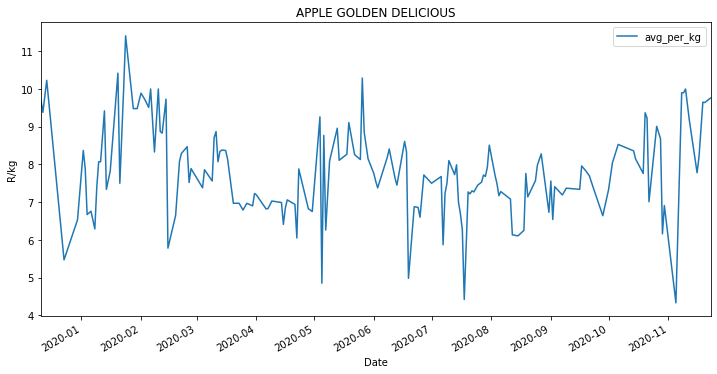

In [43]:
ax = price.plot(figsize=(12,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

In [44]:
# Create a copy so as to add some columns to the copied dataframe and not the original
copy_price = price.copy()

In [45]:
# Simple Moving Average for different periods
copy_price['5-day-SMA'] = copy_price['avg_per_kg'].rolling(window=5).mean() # Idealy a week
copy_price['5-day-Std'] = copy_price['avg_per_kg'].rolling(window=5).std() # 

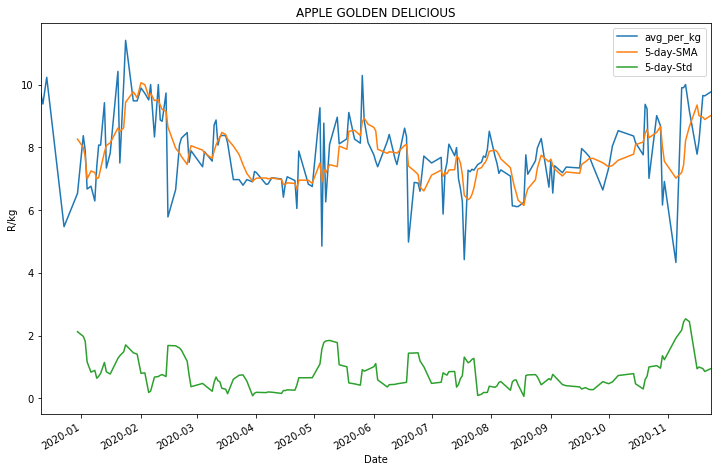

In [46]:
ax = copy_price[['avg_per_kg', '5-day-SMA', '5-day-Std']].plot(figsize=(12,8), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

## <a id="time-series-modelling">3. Time Series Modelling</a>

In [47]:
# View of the date index
price.index

DatetimeIndex(['2019-12-11', '2019-12-12', '2019-12-14', '2019-12-23',
               '2019-12-30', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-06', '2020-01-08',
               ...
               '2020-11-05', '2020-11-08', '2020-11-09', '2020-11-10',
               '2020-11-12', '2020-11-16', '2020-11-17', '2020-11-19',
               '2020-11-20', '2020-11-23'],
              dtype='datetime64[ns]', name='Date', length=168, freq=None)

The freq of the index is currently set to None, this will need to be changed to daily, since the frequency of the data is daily. Furthermore, since there is no data available for weekends, the freq has to be set to Business day (Mon-Fri), with a backfill method to account for those days when it is a holiday and no data updated. 

In [48]:
#price = price.asfreq('B', method='backfill')
price = price.asfreq('B')

In [49]:
price.head(10)

,avg_per_kg
Date,
2019-12-11,9.70
2019-12-12,9.38
2019-12-13,NaN
2019-12-16,NaN
2019-12-17,NaN
2019-12-18,NaN
2019-12-19,NaN
2019-12-20,NaN
2019-12-23,5.47


In [50]:
price.interpolate(inplace=True)

### <a id="hodrick-prescott-filter">3.1 Hodrick-Prescott filter</a>

The Hodrick-Prescott filter is used to get the trend of the data. This approach separates the time-series into a trend component and a cyclical component.

In [51]:
price_cycle, price_trend = hpfilter(price)

In [52]:
price['trend'] = price_trend

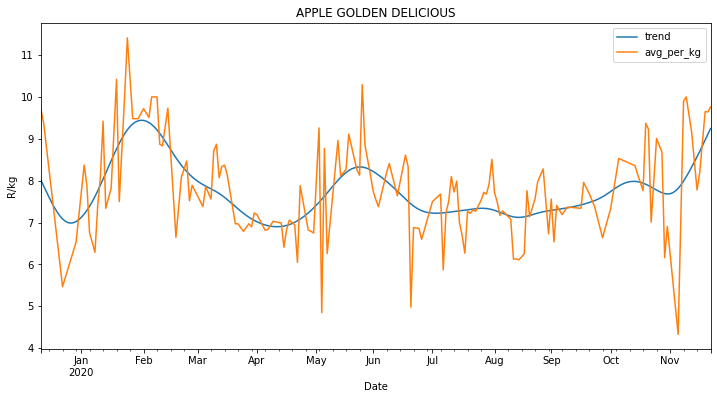

In [53]:
ax = price[['trend','avg_per_kg']].plot(figsize=(12,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

In [54]:
del price['trend']

### <a id="seasonal-decomposition">3.2 Seasonal Decomposition</a>

Time series decomposition involves the deconstruction of the time series data into the level, trend, seasonal and noise component. The model is assumed to be additive, i.e. value of our variable is given by the summation of it's deconstructed components.
<p style="text-align: center; font-weight: bold;">
$y(t) = level + trend + seasonality + noise$
</p>

In [55]:
rcParams['figure.figsize'] = 12,8

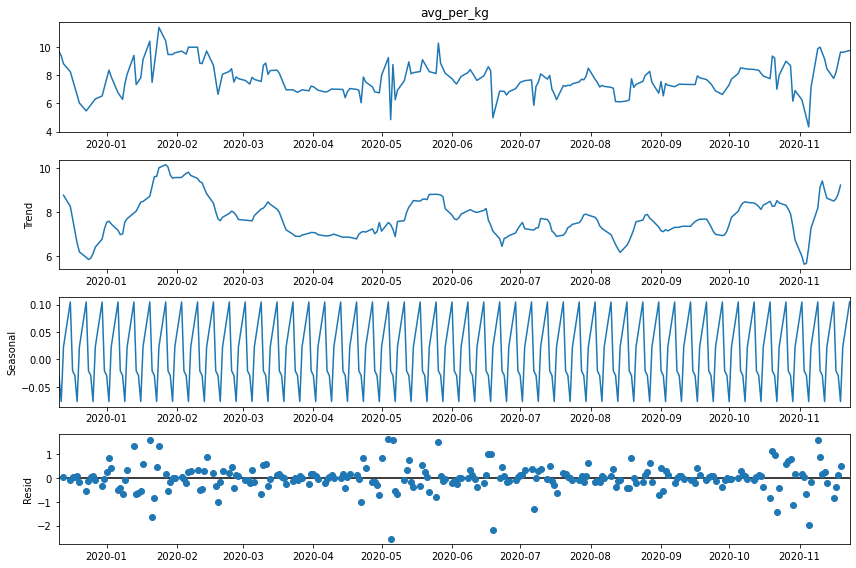

In [56]:
result = seasonal_decompose(price['avg_per_kg'], model='additive')  
result.plot();

### <a id="forecasting">3.3 Forecasting</a>

**Holt - Winters method**

Holt - Winters method is a generalized exponential smooothing method that incorporates **trend** and **seasonal** variation in the model. The model makes use of exponential weighting of the coefficients of past observations in order to give more weight to the most recent observations. 

In [57]:
train_data = price.iloc[:-30]
test_data = price.iloc[-30:]

In [59]:
model = ExponentialSmoothing(train_data['avg_per_kg'], trend='add',seasonal='add',seasonal_periods=7) 
# seasonal_periods=7 for daily data
fitted_model = model.fit()

In [60]:
test_predictions = fitted_model.forecast(30).rename('Forecast')

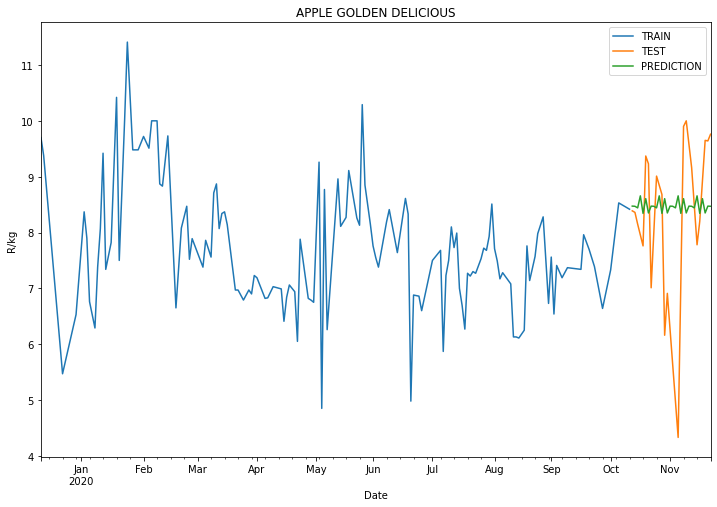

In [62]:
train_data['avg_per_kg'].plot(legend=True, label='TRAIN')
test_data['avg_per_kg'].plot(legend=True, label='TEST')
ax = test_predictions.plot(legend=True, label='PREDICTION', title="APPLE GOLDEN DELICIOUS")
ax.set(ylabel="R/kg");

In [80]:
hw_pred = np.sqrt(mean_squared_error(test_data, test_predictions))

In [81]:
hw_pred

1.528773515780376

**Autoregressive (AR) model**

The Holt-Winters method forecasts the variable of interest using a linear combination of predictors. These predictors are the set of level, trend and seasonal predictors. 

The autoregression model uses a linear combination of past values of the variable. This is a regression equation whereby the variable of interest is regressed against a set of it's lagged values of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

In [ ]:
def ar_model(data, lags=1):
    """
    Parameters
    -----------
    data: pd.Series
        A pandas series with a datetime index, and has frequency of the data specied 
    lags: int
        The number of lags that the AutoRegressive model will use
        
    Returns
    
    """
    

In [82]:
model = AR(train_data['avg_per_kg'])

In [83]:
# AR(1) model
ar1 = model.fit(maxlag=1)

In [84]:
# This is the general format for obtaining predictions
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = ar1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [85]:
model = AR(train_data['avg_per_kg'])
# AR(2) model
ar2 = model.fit(maxlag=2)
predictions2 = ar2.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

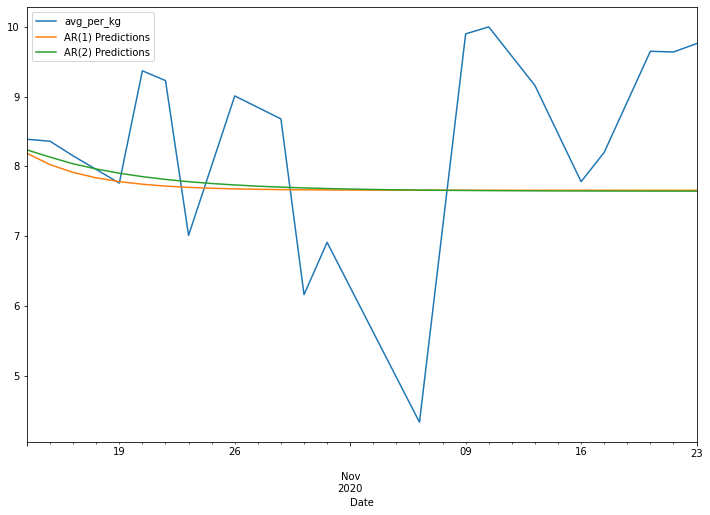

In [86]:
test_data['avg_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True);

### AR(5) model

In [59]:
model = AR(train_data['avg_per_kg'])
ar5 = model.fit(maxlag=5)
predictions5 = ar5.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')

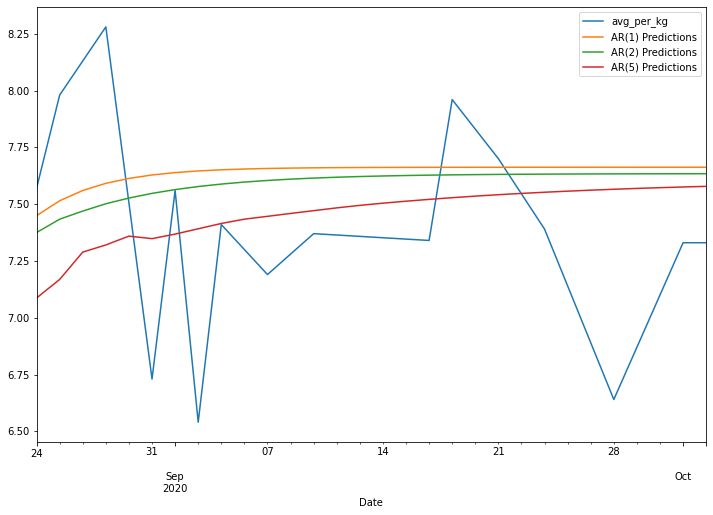

In [60]:
test_data['avg_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions5.plot(legend=True);

In [61]:
# Identify the best AR() model to use for forecasting
model = AR(train_data['avg_per_kg'])
arfit = model.fit(maxiter=1000)

In [62]:
arfit.params

const             1.501229
L1.avg_per_kg     0.470274
L2.avg_per_kg     0.169606
L3.avg_per_kg    -0.059055
L4.avg_per_kg     0.101299
L5.avg_per_kg     0.203538
L6.avg_per_kg    -0.026130
L7.avg_per_kg    -0.017899
L8.avg_per_kg    -0.085835
L9.avg_per_kg     0.126011
L10.avg_per_kg   -0.093979
L11.avg_per_kg    0.038232
L12.avg_per_kg    0.041514
L13.avg_per_kg   -0.098035
L14.avg_per_kg    0.037857
dtype: float64

### AR(14) model

In [63]:
model = AR(train_data['avg_per_kg'])
ar14 = model.fit(maxlag=14)
predictions14 = ar14.predict(start=start, end=end, dynamic=False).rename('AR(14) Predictions')

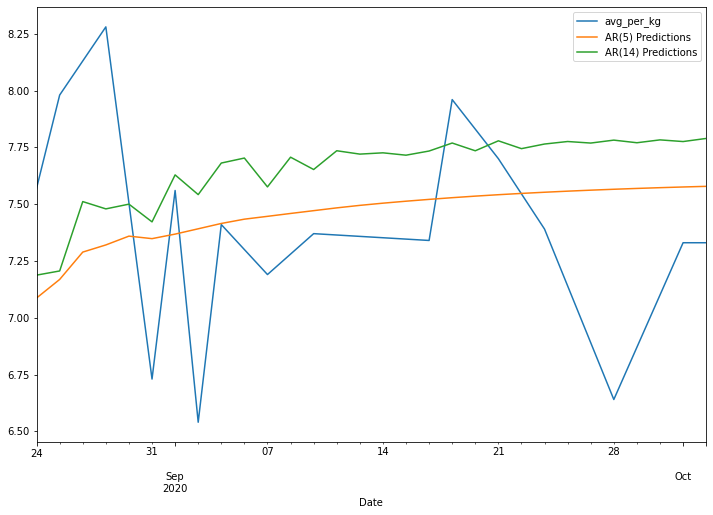

In [64]:
test_data['avg_per_kg'].plot(legend=True)
predictions5.plot(legend=True)
predictions14.plot(legend=True);

## Autoregressive Moving Average (ARMA) model

ARMA model is a combination of two models, the AR model utilizing past values of the time series data, and the Moving Average (MA) model, which uses past values of the forecast errors. 

### $$ y_{t} = c + \sum^p_{i=1} \phi_{i} y_{t-i} + \sum^q_{j=1} \theta_{j} \varepsilon_{t-j} + \varepsilon_{t} $$

As seen earlier, this models can be also be used separately, or in this section, combined. The fitting process returns estimated coefficients, $\phi_{i}$ and $\theta_{i}$, but prior to this process, the order ($p,q$) of the model needs to be determined.

## Autoregressive Integrated Moing Average (ARIMA) model

In [67]:
model = auto_arima(train_data['avg_per_kg'],error_action='ignore', suppress_warnings=True, start_p=0, start_q=0,
                          max_p=6, max_q=3)

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -212.711
Date:                Thu, 22 Oct 2020   AIC                            431.422
Time:                        13:19:31   BIC                            441.034
Sample:                             0   HQIC                           435.319
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2322      0.124      1.875      0.061      -0.011       0.475
ma.L1         -0.6612      0.115     -5.750      0.000      -0.887      -0.436
sigma2         0.6053      0.040     15.112      0.000       0.527       0.684
===================================================================================
Ljung-Box (Q):                       45.72   Jarque-Bera (JB):               136.09
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.46
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
from statsmodels.tsa.arima_model import ARIMA

In [70]:
model = ARIMA(train_data['avg_per_kg'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.avg_per_kg   No. Observations:                  182
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -212.630
Method:                       css-mle   S.D. of innovations              0.778
Date:                Thu, 22 Oct 2020   AIC                            433.260
Time:                        13:19:44   BIC                            446.076
Sample:                    12-12-2019   HQIC                           438.455
                         - 08-21-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0103      0.026     -0.403      0.687      -0.061       0.040
ar.L1.D.avg_per_kg     0.2325      0.158      1.475      0.140      -0.076       0.541
ma.L1.D.avg_per_kg    -0.6623      0.128     -5.173      0.000      -0.913      -0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3015           +0.0000j            4.3015            0.0000
MA.1            1.5099           +0.0000j            1.5099            0.0000
-----------------------------------------------------------------------------
"""

In [79]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start, end=end, typ='levels').rename("ARIMA(1,1,1) predictions")

In [80]:
#predictions = pd.Series(predictions, index=test_data.index)

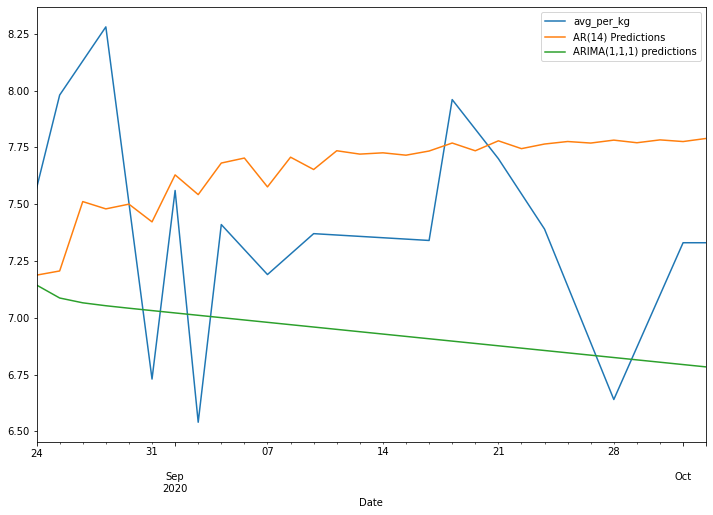

In [81]:
test_data['avg_per_kg'].plot(legend=True)
predictions14.plot(legend=True)
predictions.plot(legend=True);

### Still needs to be looked at
- Granger Causality Test
- Vector AutoRegression (VAR) methods